In [1]:
from helpers.warp import *
from detection_to_fen import *
import chess
from torchvision.utils import draw_bounding_boxes
import matplotlib.pyplot as plt

In [2]:
device = "cpu"
if torch.cuda.is_available():
    print('running cuda...')
    device = "cuda"
elif torch.backends.mps.is_available():
    print('running mps...')
    device = "mps"

In [3]:
from dataloader import PieceDetectorDataset, BoardDetectorDataset
piece_dataset = PieceDetectorDataset(root='dataloader/data/data_generation/images',
                               json_file='dataloader/data/data_generation/images/piece_coco.json')
board_dataset = BoardDetectorDataset(root='dataloader/data/data_generation/images',
                               json_file='dataloader/data/data_generation/images/board_coco.json')

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Piece Detector Dataset initialized!
Board Detector Dataset initalized!


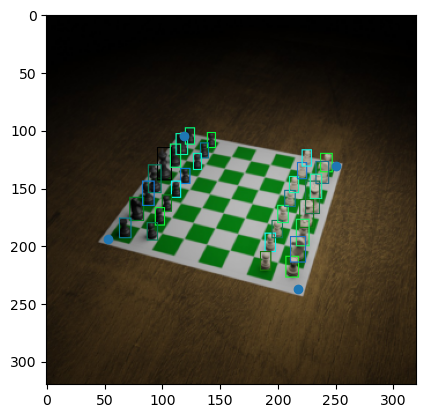

In [6]:
idx = 3
img, target = piece_dataset[idx]
_, coords = board_dataset[idx]
coords *= 320
img = (img * 255).to(torch.uint8)
bbox_img = draw_bounding_boxes(img, target['boxes'])
plt.imshow(bbox_img.detach().cpu().permute(1, 2, 0))
plt.scatter(coords[0::2], coords[1::2])
plt.show()

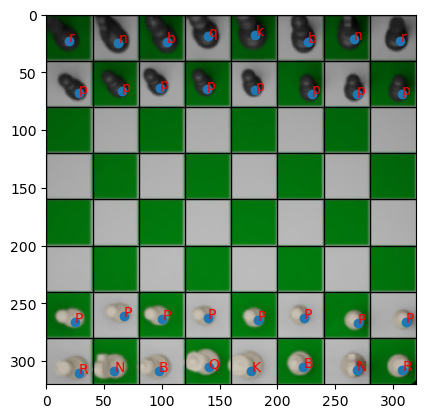

In [77]:
img, bboxes, labels, coords = get_actual(1, piece_dataset=piece_dataset, board_dataset=board_dataset)
# _, _, _, coords = get_actual(5)
points = bboxes_to_points(bboxes, offset=1.5)
warped_img, M = warp(img, reshape_coords(coords), device=device)
warped_points = transform_points(M, points)
fen = calculateFEN(warped_points[0], labels)

out = warped_points.transpose(1, 2)[0]
plt.imshow(warped_img[0].to('cpu').to(torch.uint8).permute(1, 2, 0))
plt.scatter(out[0].detach().to('cpu'), out[1].detach().to('cpu'))
for i, label in enumerate(labels):
    plt.annotate(label, (out[0][i], out[1][i]), color='red')
for i in range(8):
    plt.axhline(y=i * 40, color='black', linewidth=1)
    plt.axvline(x=i * 40, color='black', linewidth=1)
plt.xlim([0, 320])
plt.ylim([320, 0])
plt.show()

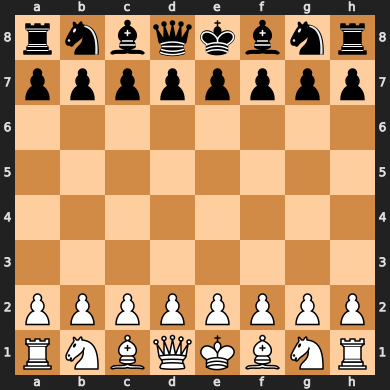

In [78]:
chess.Board(fen)

In [79]:
def calc_coord(grid_cell):
    # thanks to bing chat
    """
        grid_cell: (0, 0) is a1, (0, 1) is a2
                    (1, 0) is b1, ...
    """
    board_scale = 1.215
    x_range = (-board_scale, board_scale)
    y_range = (-board_scale, board_scale)
    num_cells = 8
    cell_width = (x_range[1] - x_range[0]) / num_cells
    cell_height = (y_range[1] - y_range[0]) / num_cells
    row = grid_cell[0]
    col = grid_cell[1]
    x_center = x_range[0] + cell_width * (col + 0.5)
    y_center = y_range[0] + cell_height * (row + 0.5)
    return (x_center, y_center)

In [114]:
fen = 'rnbqkbnr/pppppppp/8/8/8/8/PPPPPPPP/RNBQKBNR w KQkq - 0 1'
fen = fen.split(' ')[0]

def print_board(fen):
    rows = fen.split('/')
    for y in range(8):
        row = rows[7-y]
        x = 0
        for c in row:
            if c.isdigit():
                x += int(c)
            else:
                print(f'({x}, {y}): {c}')
                x += 1
print_board(fen)

(0, 0): R
(1, 0): N
(2, 0): B
(3, 0): Q
(4, 0): K
(5, 0): B
(6, 0): N
(7, 0): R
(0, 1): P
(1, 1): P
(2, 1): P
(3, 1): P
(4, 1): P
(5, 1): P
(6, 1): P
(7, 1): P
(0, 6): p
(1, 6): p
(2, 6): p
(3, 6): p
(4, 6): p
(5, 6): p
(6, 6): p
(7, 6): p
(0, 7): r
(1, 7): n
(2, 7): b
(3, 7): q
(4, 7): k
(5, 7): b
(6, 7): n
(7, 7): r


AttributeError: 'list' object has no attribute 'split'